In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os,sys,inspect
import gc
from tqdm import tqdm
import random

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from load import *
from evals import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input, Embedding, Flatten, Multiply
from tensorflow.keras.models import Model, Sequential, load_model

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

## Load

In [3]:
df = load_data('../data/ml-100k/u.data')

uuid = df['userId'].unique()
uiid = df['movieId'].unique()


In [4]:
df = add_negative(df, uiid, 4)

idx = list(df.index)
np.random.shuffle(idx)
df = df.loc[idx]

rtd = extract_from_df(df, 2, 0)

train = df.drop(rtd)

val = df.loc[rtd]
rtd = extract_from_df(val, 1, 0)
test = val.drop(rtd)
val = val.loc[rtd]

100%|██████████| 943/943 [00:02<00:00, 369.29it/s]


## Model

### Simpler version

In [5]:
def build_gmf(u_dim, i_dim, gmf_dim):
    u_input = Input(shape=(1, ))
    i_input = Input(shape=(1, ))

    u_emb_gmf = Flatten()(Embedding(u_dim, gmf_dim, input_length=u_input.shape[1])(u_input))
    i_emb_gmf = Flatten()(Embedding(i_dim, gmf_dim, input_length=i_input.shape[1])(i_input))

    # gmf
    mul = Multiply()([u_emb_gmf, i_emb_gmf])

    out = Dense(1)(mul)

    return Model([u_input, i_input], out, name='GMF')

def build_mlp(u_dim, i_dim, mlp_dim):
    u_input = Input(shape=(1, ))
    i_input = Input(shape=(1, ))
    
    u_emb_mlp = Flatten()(Embedding(u_dim, mlp_dim, input_length=u_input.shape[1])(u_input))
    i_emb_mlp = Flatten()(Embedding(i_dim, mlp_dim, input_length=i_input.shape[1])(i_input))

    # mlp
    concat = Concatenate()([u_emb_mlp, i_emb_mlp])

    h = Dense(128, activation='relu')(concat)
#     h = Dropout(0.2)(h)
    h = Dense(64, activation='relu')(h)
    h = Dropout(0.2)(h)

    out = Dense(1)(h)

    return Model([u_input, i_input], out, name='MLP')

def build_nmf(u_dim, i_dim, gmf_dim, mlp_dim):
    u_input = Input(shape=(1, ))
    i_input = Input(shape=(1, ))

    u_emb_gmf = Flatten()(Embedding(u_dim, gmf_dim, input_length=u_input.shape[1])(u_input))
    i_emb_gmf = Flatten()(Embedding(i_dim, gmf_dim, input_length=i_input.shape[1])(i_input))

    u_emb_mlp = Flatten()(Embedding(u_dim, mlp_dim, input_length=u_input.shape[1])(u_input))
    i_emb_mlp = Flatten()(Embedding(i_dim, mlp_dim, input_length=i_input.shape[1])(i_input))

    # gmf
    mul = Multiply()([u_emb_gmf, i_emb_gmf])

    # mlp
    concat = Concatenate()([u_emb_mlp, i_emb_mlp])

    h = Dense(128, activation='relu')(concat)
#     h = Dropout(0.2)(h)
    h = Dense(64, activation='relu')(h)
    h = Dropout(0.2)(h)

    con = Concatenate()([mul, h])

    out = Dense(1)(con)

    return Model([u_input, i_input], out, name='NMF')

## Train

In [6]:
class ValCallback(callbacks.Callback):
    def __init__(self):
        self.best_score = 0
        self.bw = None
        self.score_hist = []
        self.score_hist_ = []
    
    def on_epoch_end(self, epochs, logs=None):
        if epochs%1 == 0:
            uid = np.random.choice(uuid, int(len(uuid)*0.3), replace=False)
            hits = list(map(eval_hit_wrapper(self.model, train, val, uiid, 10), uid))
            score = sum(hits)
            self.score_hist.append(score)
            self.score_hist_.append(score/len(hits))
            if self.best_score < score:
                self.bw = self.model.get_weights()
                self.best_score = score

In [7]:
gmf = build_gmf(len(uuid), len(uiid), 16)
gmf.compile(optimizer=optimizers.Adam(2e-4), loss=losses.BinaryCrossentropy(from_logits=True))

gmf_cb = ValCallback()

hist_gmf = gmf.fit([train['userId'].values, train['movieId'].values],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                  callbacks=[gmf_cb],
                  validation_split=0.1)

Epoch 1/10
13549/13549 [==============================] - 45s 3ms/step - loss: 0.5087 - val_loss: 0.3842
Epoch 2/10
13549/13549 [==============================] - 47s 3ms/step - loss: 0.3613 - val_loss: 0.3588
Epoch 3/10
13549/13549 [==============================] - 48s 4ms/step - loss: 0.3481 - val_loss: 0.3473
Epoch 4/10
13549/13549 [==============================] - 46s 3ms/step - loss: 0.3302 - val_loss: 0.3299
Epoch 5/10
13549/13549 [==============================] - 46s 3ms/step - loss: 0.3110 - val_loss: 0.3169
Epoch 6/10
13549/13549 [==============================] - 46s 3ms/step - loss: 0.2985 - val_loss: 0.3103
Epoch 7/10
13549/13549 [==============================] - 47s 3ms/step - loss: 0.2912 - val_loss: 0.3062
Epoch 8/10
13549/13549 [==============================] - 47s 3ms/step - loss: 0.2856 - val_loss: 0.3027
Epoch 9/10
13549/13549 [==============================] - 48s 4ms/step - loss: 0.2801 - val_loss: 0.2991
Epoch 10/10
13549/13549 [==============================

In [8]:
mlp = build_mlp(len(uuid), len(uiid), 16)
mlp.compile(optimizer=optimizers.Adam(2e-4), loss=losses.BinaryCrossentropy(from_logits=True))

mlp_cb = ValCallback()

hist_mlp = mlp.fit([train['userId'].values, train['movieId'].values],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                  callbacks=[mlp_cb],
                  validation_split=0.1)

Epoch 1/10
13549/13549 [==============================] - 55s 4ms/step - loss: 0.3746 - val_loss: 0.3591
Epoch 2/10
13549/13549 [==============================] - 55s 4ms/step - loss: 0.3540 - val_loss: 0.3501
Epoch 3/10
13549/13549 [==============================] - 54s 4ms/step - loss: 0.3286 - val_loss: 0.3224
Epoch 4/10
13549/13549 [==============================] - 54s 4ms/step - loss: 0.3111 - val_loss: 0.3144
Epoch 5/10
13549/13549 [==============================] - 55s 4ms/step - loss: 0.3013 - val_loss: 0.3071
Epoch 6/10
13549/13549 [==============================] - 54s 4ms/step - loss: 0.2909 - val_loss: 0.3002
Epoch 7/10
13549/13549 [==============================] - 54s 4ms/step - loss: 0.2828 - val_loss: 0.2958
Epoch 8/10
13549/13549 [==============================] - 54s 4ms/step - loss: 0.2769 - val_loss: 0.2939
Epoch 9/10
13549/13549 [==============================] - 54s 4ms/step - loss: 0.2717 - val_loss: 0.2909
Epoch 10/10
13549/13549 [==============================

In [9]:
nmf = build_nmf(len(uuid), len(uiid), 16, 16)
nmf.compile(optimizer=optimizers.Adam(2e-4), loss=losses.BinaryCrossentropy(from_logits=True))

nmf_cb = ValCallback()

hist_nmf = nmf.fit([train['userId'].values, train['movieId'].values],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                  callbacks=[nmf_cb],
                  validation_split=0.1)

Epoch 1/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.3746 - val_loss: 0.3589
Epoch 2/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.3430 - val_loss: 0.3292
Epoch 3/10
13549/13549 [==============================] - 60s 4ms/step - loss: 0.3054 - val_loss: 0.3061
Epoch 4/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.2848 - val_loss: 0.2971
Epoch 5/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.2705 - val_loss: 0.2905
Epoch 6/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.2586 - val_loss: 0.2859
Epoch 7/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.2488 - val_loss: 0.2823
Epoch 8/10
13549/13549 [==============================] - 59s 4ms/step - loss: 0.2403 - val_loss: 0.2822
Epoch 9/10
13549/13549 [==============================] - 60s 4ms/step - loss: 0.2327 - val_loss: 0.2811
Epoch 10/10
13549/13549 [==============================

## Eval

### Losses

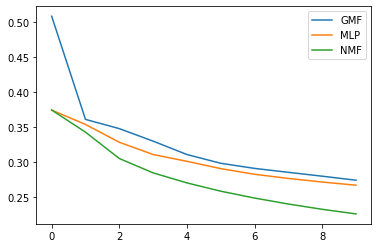

In [10]:
plt.plot(hist_gmf.history['loss'], label='GMF')
plt.plot(hist_mlp.history['loss'], label='MLP')
plt.plot(hist_nmf.history['loss'], label='NMF')
plt.legend()

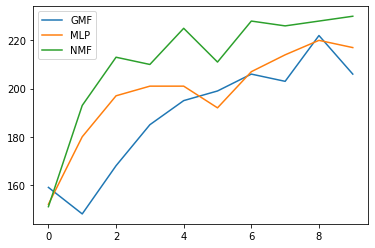

In [11]:
plt.plot(gmf_cb.score_hist, label='GMF')
plt.plot(mlp_cb.score_hist, label='MLP')
plt.plot(nmf_cb.score_hist, label='NMF')
plt.legend()

### Hit@10

#### GMF

In [12]:
%%time
hits_gmf10 = list(map(eval_hit_wrapper(gmf, train, test, uiid, 10), uuid))
print(sum(hits_gmf10)/len(hits_gmf10))

0.782608695652174
Wall time: 53 s


#### MLP

In [13]:
hits_mlp10 = list(map(eval_hit_wrapper(mlp, train, test, uiid, 10), uuid))
print(sum(hits_mlp10)/len(hits_mlp10))

0.8016967126193001


#### NMF

In [14]:
hits_nmf10 = list(map(eval_hit_wrapper(nmf, train, test, uiid, 10), uuid))
print(sum(hits_nmf10)/len(hits_nmf10))

0.809119830328738


### NDCG@10

#### GMF

In [15]:
%%time
ndcg_gmf10 = list(map(eval_NDCG_wrapper(gmf, train, test, uiid, 10), uuid))
print(sum(ndcg_gmf10)/len(ndcg_gmf10))

0.3574474090414622
Wall time: 54.3 s


#### MLP

In [16]:
ndcg_mlp10 = list(map(eval_NDCG_wrapper(mlp, train, test, uiid, 10), uuid))
print(sum(ndcg_mlp10)/len(ndcg_mlp10))

0.3836345815475264


#### NMF

In [17]:
ndcg_nmf10 = list(map(eval_NDCG_wrapper(nmf, train, test, uiid, 10), uuid))
print(sum(ndcg_nmf10)/len(ndcg_nmf10))

0.3448815446915423
